In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## Import A/B test data ##

In [89]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [83]:
df.shape

(294478, 5)

In [84]:
df['converted'].value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [85]:
pd.crosstab(df['group'], df['landing_page'])
# we need to get rid of the 1928 control group seeing the new page
# and the 1965 treatment group seeing the old page

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [90]:
# see if there are duplicate users
sessions = df['user_id'].value_counts()

sessions[sessions > 1].count() # 3894 duplicate users need to be dropped

3894

In [91]:
have_to_drop = sessions[sessions > 1].index

df = df[~df['user_id'].isin(have_to_drop)]

df.shape[0] # 286690 rows now

286690

## Select the ideal sample size using Power Analysis ##

In [93]:
sample_size = sms.NormalIndPower().solve_power(
    sms.proportion_effectsize(0.13, 0.15),        # the effect size based on our expected rates of 13% and 15%
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                 

sample_size = math.ceil(sample_size)              # Rounding up to next whole number                          

print(sample_size)                                # 4720 is the ideal sample size

4720


## Random Sample ##

In [95]:
control_sample = df[df['group'] == 'control'].sample(n = sample_size, random_state = 22)

treatment_sample = df[df['group'] == 'treatment'].sample(n = sample_size, random_state = 22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)

ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0


In [96]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
user_id         9440 non-null int64
timestamp       9440 non-null object
group           9440 non-null object
landing_page    9440 non-null object
converted       9440 non-null int64
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [97]:
# make sure sampling was done correctly
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

## Basic Visualizations ##

In [106]:
# Conversion Rates

conversion_rates = ab_test.groupby('group')['converted'].agg([np.mean, np.std, stats.sem])

conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')   # similar conversion rates (12.3%, 12.6%) for both groups at first glance

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Text(0, 0.5, 'Converted (proportion)')

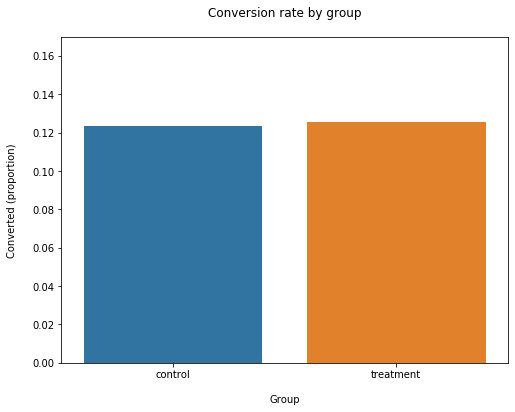

In [112]:
# graph this

plt.figure(figsize=(8,6))

sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

## Hypothesis Testing ##

In [118]:
# Z-test

# Null hypothesis H0: new design conversion rate = new design conversion rate
# Alternative hypothesis H1: new design conversion rate != new design conversion rate

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_control = control_results.count()
n_treatment = treatment_results.count()
success = [control_results.sum(), treatment_results.sum()]
nobs = [n_control, n_treatment]

z_stat, pval = proportions_ztest(success, nobs = nobs)
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(success, nobs = nobs, alpha=0.05)   # 95% CI

print(f'z statistic is {z_stat:.2f}')
print(f'p-value is {pval:.3f}')
print(f'95% CI for control group is [{lower_control:.3f}, {upper_control:.3f}]')
print(f'95% CI for treatment group is [{lower_treatment:.3f}, {upper_treatment:.3f}]')

z statistic is -0.34
p-value is 0.732
95% CI for control group is [0.114, 0.133]
95% CI for treatment group is [0.116, 0.135]


In [ ]:
# Results:
# P-value of 0.732 is way above 0.05 
# -> we cannot reject the null hypothesis 
# -> new design did not perform significantly different than the old design :(